In [1]:
import numpy as np
import pandas as pd
import datetime
import matplotlib.pyplot as plt
import scipy
from scipy import stats
%pylab inline
from matplotlib import pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from mpl_toolkits.mplot3d import proj3d
import statsmodels.formula.api as smf
import sklearn
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
import shapefile

Populating the interactive namespace from numpy and matplotlib


## The Logistic Classifier

Regression techniques are typically used for predicting the real-valued output. But what is the output is discrete and even binary - 0 and 1 - i.e. what if we are dealing with a binary classification problem based on the real-valued input variables? 

Consider a training sample of size $N$ for a binary output variable 
$${\displaystyle y = }
\left\{ \begin{array}{l l} 
{1} & \quad \text{event happened }\\ 
{0} & \quad \text{event not happened } \\
\end{array} \right.
$$
and $n$ regressors $x^j$: 
$$
X=\{x_i, i=1..N\}=\{x_i^j, i=1..N, j=1..n\},\ Y=\{y_i, i=1..N\}.
$$ 

As before, instead of trying to predict the spefic value of $y$, we admit its uncertainty considering it a binary random variable, trying to predict its probability distribution (Bernoulli as the only meaningfull one for a binary variable):

$$
P(y|x,\beta)=Bern(y|\mu(x,\beta))
$$

A simplest suggestion for $\mu$ would be a linear model:

$$
\mu(x,\beta)=x\beta,
$$

however as $\mu=P(d=1)$ is the probability, it can only take values between 0 to 1, while there is no good way to ensure that the linear form $x\beta$ taked value within this interval. This could be corrected by considering 
$$
\mu(x,\beta)=f(x\beta),
$$
where $f$ is a certain function taking values only between 0 and 1. As for this function $f$, one can select a sigmoid function
$$
f(x)=\sigma(x)=\frac{e^x}{1+e^x}=\frac{1}{1+e^{-x}}.
$$
Sigmoid function always takes values within the interval $(0,1)$. This way 

$$
{\displaystyle P(y=1) = \sigma(x\beta)=\frac{\exp(x\beta)}{1+\exp(x\beta)}}=\frac{1}{1+\exp(-x\beta)}
$$$$
\displaystyle P(y=0) = 1-P(y=1)=\frac{1}{1+\exp(x\beta)}
$$

Then the likelihood of getting observed values of the output variable $y_i$ corresponding to the inputs $x_i$ can be defined as
$$
L=\prod\limits_i P(y=y_i|x_i,\beta),
$$
while log-likelihood is
$$
log(L)=\sum\limits_i log\left(P(y=y_i|x_i,\beta)\right)=\sum\limits_i y_i log\left(P(y=1|x_i,\beta)\right)+
\sum\limits_i (1-y_i)log\left(P(y=0|x_i,\beta)\right)=
$$$$
-\sum\limits_i log\left(1+exp((2 y_i-1)x_i\beta)\right).
$$
Then
$$
\beta=argmin_{\beta} \sum\limits_i log\left(1+exp((2 y_i-1)x_i\beta)\right).
$$
The above optimization problem can no longer be solved in the closed analytic form, but instead a multivariate iterational numerical optimization heuristics, such as various gradient decent methods, could be applied. 

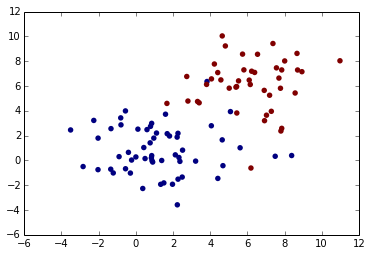

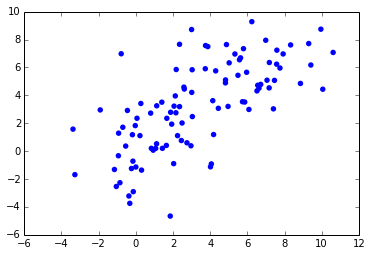

In [2]:
# generate some random 2d data points around two centroid points classified based on which of the centroids was used
random.seed(2015)
label0=stats.bernoulli.rvs(p = 0.4, size = 200)
xc=np.array([1,6])
yc=np.array([1,6])
x=xc[np.array(label0)]+stats.norm.rvs(0, 2, size = 200)
y=yc[np.array(label0)]+stats.norm.rvs(0, 2, size = 200)

#split into training and validation sample

xt=x[0:100]
yt=y[0:100]
xv=x[100:200]
yv=y[100:200]
lt=label0[0:100]
lv=label0[100:200]

#visualize classified training set and test set to be classified

plt.figure()
plt.scatter(xt,yt,c=lt.astype(np.float),s=30,lw=0)
plt.figure()
plt.scatter(xv,yv,s=30,lw=0)

#transform to matrices

#Xt=np.append(xt,yt).reshape(2,100).transpose()
#Xv=np.append(xv,yv).reshape(2,100).transpose()

train=pd.DataFrame({'Y':lt,'X1':xt,'X2':yt})
test=pd.DataFrame({'Y':lv,'X1':xv,'X2':yv})

Optimization terminated successfully.
         Current function value: 0.134472
         Iterations 9


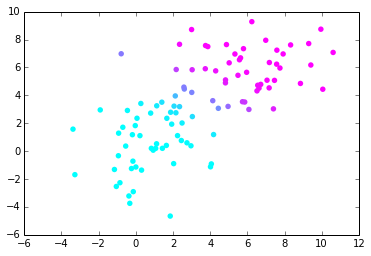

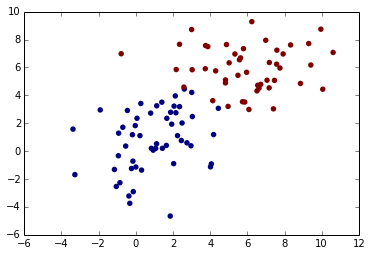

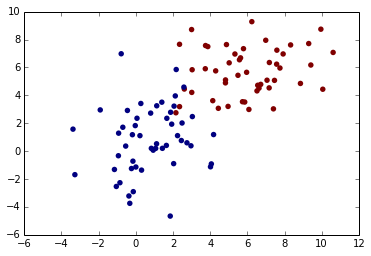

In [3]:
#learn logistic regression over the training sample
logit = smf.logit('Y ~ X1 + X2', data = train).fit()
#apply to the validation sample
le=logit.predict(test)
#visualize the probabilities
plt.figure()
plt.scatter(xv,yv,c=le,s=30,lw=0,cmap='cool')
#visualize the classification
le=le>0.5
plt.figure()
plt.scatter(xv,yv,c=le,s=30,lw=0)
#visualize the "true" test classification
plt.figure()
plt.scatter(xv,yv,c=lv,s=30,lw=0)

## Confusion matrix

Fit of the binary classificator over the selected test set can be characterized by the confusion matrix
$$
\left[\begin{array}{c|c}TP&FN\\
\hline
FP&TN\end{array}\right]
$$
where $TP$ - is number of true positives (correctly classified positives ($y_i=1$)), 
$FP$ - number of false positives (observed negatives ($y_i=0$) incorrectly classified as positives ($y_i=1$)), 
$FN$ - number of false negatives (observed positives ($y_i=1$) incorrectly classified as negatives ($y_i=0$)), 
$TN$ - number of true negatives (correctly classified negatives ($y_i=0$)).

In relative terms the following quantities are often considered:

precision or positive predictive value (fraction of true positive classifications among all actual positive observations):
$$
PPV=\frac{TP}{TP+FP},
$$
sensitivity or recall or true positive rate (fraction of true positives among all positive classifications):
$$
TPR=\frac{TP}{TP+FN},
$$
accuracy (fraction of true classifications among all instances considered)
$$
ACC=\frac{TP+TN}{TP+TN+FP+FN}.
$$

In [4]:
#compute TP,FP,FN,TN for the above classification
TP=sum((le==1)&(lv==1))
FP=sum((le==1)&(lv==0))
FN=sum((le==0)&(lv==1))
TN=sum((le==0)&(lv==0))
#compute precision, accuracy and recall
ACC=100.0*(TP+TN)/(TP+TN+FP+FN)
Recall=100.0*TP/(TP+FN)
Prec=100.0*TP/(TP+FP)
print('Precision={0}, Accuracy={1}, Recall={2}'.format(Prec,ACC,Recall))

Precision=93.6170212766, Accuracy=92.0, Recall=89.7959183673


### Interpreting logit coeffients and statistics
Example - learning the probability of school admission based on marks and school type

In [5]:
# Read in some data on graduate school admissions.  These data are fictional, but serve as a useful example.

data = pd.read_csv("http://www.ats.ucla.edu/stat/data/binary.csv")
print data.info()
print data.describe()
# split sample into training and test ones
random.seed(2015)
ind=stats.bernoulli.rvs(p = 0.6, size = 400)
train=data[ind==1]
test=data[ind==0]

<class 'pandas.core.frame.DataFrame'>
Int64Index: 400 entries, 0 to 399
Data columns (total 4 columns):
admit    400 non-null int64
gre      400 non-null int64
gpa      400 non-null float64
rank     400 non-null int64
dtypes: float64(1), int64(3)
memory usage: 15.6 KB
None
            admit         gre         gpa       rank
count  400.000000  400.000000  400.000000  400.00000
mean     0.317500  587.700000    3.389900    2.48500
std      0.466087  115.516536    0.380567    0.94446
min      0.000000  220.000000    2.260000    1.00000
25%      0.000000  520.000000    3.130000    2.00000
50%      0.000000  580.000000    3.395000    2.00000
75%      1.000000  660.000000    3.670000    3.00000
max      1.000000  800.000000    4.000000    4.00000


In [6]:
test.shape

(176, 4)

In [7]:
# School rank is a categorical feature, and we should capture this aspect using C(rank)
# C(rank) tells statsmodels to convert the categorical variable into dummy indicator variables 
# and omit one of them
# The omitted categorical indicator is the reference category.

# Make a prediction, the probability of admission or Pr(d=1), 
# using the logistic formula above.
# Average features at rank 2 school.
logit = smf.logit('admit ~ gpa + gre + C(rank)', data = train).fit()
# logit = smf.logit('admit ~ gpa + C(rank)', data = train).fit()
print(logit.summary())
pre = logit.predict(test)>0.5

#compute TP,FP,FN,TN for the above classification
TP=sum((pre==1)&(test.admit==1))
FP=sum((pre==1)&(test.admit==0))
FN=sum((pre==0)&(test.admit==1))
TN=sum((pre==0)&(test.admit==0))
#compute precision, accuracy and recall
ACC=100.0*(TP+TN)/(TP+TN+FP+FN)
Recall=100.0*TP/(TP+FN)
Prec=100.0*TP/(TP+FP)
print('Precision={0}, Accuracy={1}, Recall={2}'.format(Prec,ACC,Recall))

Optimization terminated successfully.
         Current function value: 0.578491
         Iterations 5
                           Logit Regression Results                           
Dep. Variable:                  admit   No. Observations:                  224
Model:                          Logit   Df Residuals:                      218
Method:                           MLE   Df Model:                            5
Date:                Tue, 13 Oct 2015   Pseudo R-squ.:                 0.06858
Time:                        08:14:25   Log-Likelihood:                -129.58
converged:                       True   LL-Null:                       -139.12
                                        LLR p-value:                  0.001855
                   coef    std err          z      P>|z|      [95.0% Conf. Int.]
--------------------------------------------------------------------------------
Intercept       -3.1686      1.472     -2.153      0.031        -6.053    -0.284
C(rank)[T.2]    -0.9200

In [8]:
# interpret regression: probability of admittance to T.1,2,3,4 for gre = 650, gpa = 3.6
for k in range(1,5):
  p=logit.predict(pd.DataFrame({'gre':[650],'gpa':[3.6],'rank':[k]}))[0]  
  print('Probability of admittance to T.{0}={1}'.format(k,100*p))

Probability of admittance to T.1=61.2960165922
Probability of admittance to T.2=38.6941307263
Probability of admittance to T.3=29.6791249241
Probability of admittance to T.4=23.7997346006


# K-means clustering

What if we do not have any training data? Unsupervised approach - k-means clustering can help learning the most suitable cluster structure given a suggested number of clusters $k$. 

Works for the data samples ($N$ points) in $n$-dimensional Euclidean space: 
$$
X=\{x_i, i=1..N\}=\{x_i^j, i=1..N, j=1..n\},
$$ 
where $x_i$ are the $n$-dimensional raw-vectors corresponding to each of the $N$ sample points. The approach is trying to infer cluster indexes $c_i$ (taking one of the possible values $1,2,...,k$) for each point $x_i$ in such a way that the cumulative squared distance from all the sample points $x_i$ to the centroids $\mu_{c_i}$ of the corresponding clusters $c_i$ is minimized. This is quite an intuitive criteria, meaning that the clusters as as compact as possible for the given number $k$. The cluster centroids are defined as simple vector means
$$
\mu_c=\sum_{i, c(i)=c} x_i/m(c),
$$
where
$$
m(c)=|\{i, c(i)=c\}|
$$
denotes the cluster size. Or in the coordinate form $\mu_c=(\mu_c^j, j=1..n)$
$$
\mu_c^j=\frac{\sum_{i, c(i)=c} x_i^j}{m(c)}, j=1..n.
$$
Then the mimimal cumulatize squared distance criteria can be written as
$$
SD=\sum_i \|x_i-\mu_{c_i}\|^2=\sum_{i,j} \left(x_i^j-\mu_{c_i}^j\right)^2\to \min
$$

The common algorithm (often called after Lloyd) starts from a random cluster assignment and iterates the following two steps:

A. Compute cluster means.

B. Re-assign each point to the cluster with the mean closest to the considered point.

Alternative approach is to initially use $k$ random points of the sample as clusters means, starting from the step B.

The algorithm stops once a new iteration fails to alter any single cluster assignment.

Algorithm always converges to a local optimum of $SD$, however there is no guarantee that this partitioning is indeed the global optimum. Also the final outcome happens to depend on the initial partitioning. This way it makes sense to repreat $k$-means a number of times (like $10,25...100$ etc) with different random initial partitioning, picking up the partitioning with the best final $SD$. 

In order to figure out how many trials to consider one can keep adding them one by one tracking how do they affect the final score and stop once it stays stable for a while.


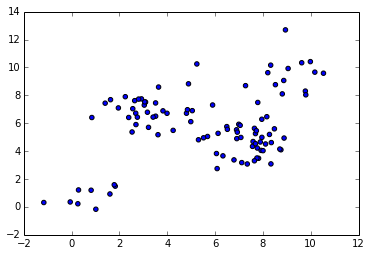

In [9]:
# prepare synthetic data
random.seed(2015)
label0=stats.binom.rvs(p = 0.5, n=3, size = 100)
xc=np.array([1,7,3,9])
yc=np.array([1,5,7,9])
x=xc[np.array(label0)]+stats.norm.rvs(0, 1, size = 100)
y=yc[np.array(label0)]+stats.norm.rvs(0, 1, size = 100)
plt.scatter(x,y,s=20)

X=np.append(x,y).reshape(2,100).transpose()

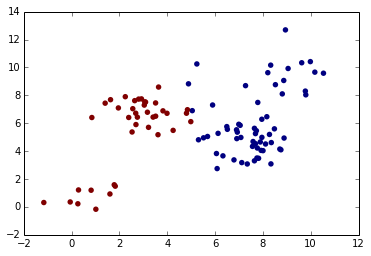

In [10]:
# try clustering with k=2 first
est=KMeans(n_clusters=2,n_init=100)
est.fit(X)
labels=est.labels_
plt.figure(figsize=(6,4))
plt.scatter (x,y,s=30,c=labels.astype(np.float),lw=0)

### Silhouette measure

In the example above we visually see that the data could still be clustered further. So how to select the appropriate number of clusters $k$ besides just naive visual observations? 

We can't use SD here anymore as the more clusters we take, the smaller it goes, and we'll get it down to zero, assigning each point to its own cluster, which is certianly not the most useful way of clustering.

We need another partitioning quality measure here. Most common option is using a Silhouette measure, which for each data point $x_i$ quantifies its relative attachement strength to its current cluster vs the closest neighbor cluster:
$$
s(i)=\frac{\min\limits_{k\neq c_i} \|x_i-\mu_{c_k}\|-\|x_i-\mu_{c_i}\|}{\max\{\|x_i-\mu_{c_i}\|,\min\limits_{k\neq c_i} \|x_i-\mu_{c_k}\|\}}.
$$

Then internal quality of the partitioning is characterized by an average ratio value of silhouette for all the data points:
$$
S=\frac{\sum\limits_i s(i)}{N}.
$$

By definition, the silhouette measure is normalized. i.e. $-1\leq s(i)\leq 1$ and so is the average: $-1\leq S\leq 1$. $S=1$ means that all the points coinside with their cluster centroids, values close to 1 mean that the points are usually much closer to their cluster centroids than to all the other ones (i.e. clustered appropriately), values of $S$ around zero mean that clustering is quite unstable, i.e. moving many of the points to another clusters might not affect its quality much; while negative values of $S$ mean that clustering could certainly be improved by moving some of the points to the other clusters.

2 clusters: 0.449945835009
3 clusters: 0.516687366064
4 clusters: 0.615282435262
5 clusters: 0.479945869479
6 clusters: 0.430836991335
7 clusters: 0.430623146954
8 clusters: 0.431112720596
9 clusters: 0.410936588169
10 clusters: 0.40469711458
11 clusters: 0.394918400089
Best for 4 clusters: 0.615282435262


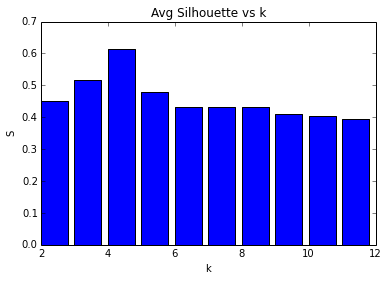

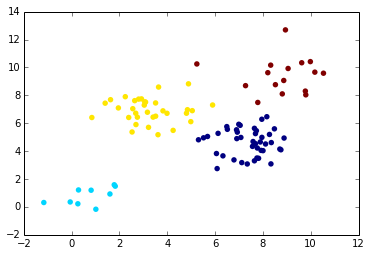

In [11]:
#perform the clustering for 10 different values of k from 2 to 11, compute the average Silhouette score for each
#and pick up the k maximizing an average Silhouette score
s=[0]*10
for k in range(0,10):
    est=KMeans(n_clusters=k+2,n_init=25)
    est.fit(X)
    s[k]=silhouette_score(X, est.labels_)
    print('{0} clusters: {1}'.format(k+2,s[k]))
k=np.argmax(s)    
est=KMeans(n_clusters=k+2,n_init=100)
est.fit(X)
labels=est.labels_
plt.figure()
plt.bar(range(2,12),s)
plt.xlabel('k')
plt.ylabel('S')
plt.title('Avg Silhouette vs k')
print('Best for {0} clusters: {1}'.format(k+2,silhouette_score(X, labels)))
plt.figure()
plt.scatter (x,y,s=30,c=labels.astype(np.float),lw=0)

# 311 data

Now let's use 311 data to provide the context of the area.

In [12]:
# read the curated data - number of complains per 1 sq mile cell and complain type as well as coordinates of the cells
data311 = pd.read_csv( 'https://serv.cusp.nyu.edu/files/ADS-2015/MorningSection/lab5/cellaggr311.csv' , index_col=0 )
cells311 = pd.read_csv( 'https://serv.cusp.nyu.edu/files/ADS-2015/MorningSection/lab5/311cells.csv' , index_col=0 )
print(data311.head())
print(cells311.head())

   Cell        CompType  Count
1     0  Adopt-A-Basket      1
2   624  Adopt-A-Basket      2
3   714  Adopt-A-Basket      1
4   724  Adopt-A-Basket      1
5   905  Adopt-A-Basket      1
   Cell          x          y  m
1     0 -74.244686  40.506004  0
2     1 -74.231099  40.508049  0
3     2 -74.213415  40.510914  0
4   100 -74.243625  40.515905  0
5   101 -74.231455  40.519908  0


In [13]:
# create a rectangular matrix of cell (raws) profiles by compain types (columns); create dictionaries and order raw metadata
import numbers
cells={}
cellinv={}
cellnum=0
complains={}
compinv={}
compnum=0
cx={}
cy={}
mh={}
X=numpy.zeros(shape=(10000,200))
for i in data311.index:
    z=data311.Cell[i];
    if not (z in cells.keys()):
          cells[z]=cellnum
          cellinv[cellnum]=z
          ci=list(cells311.Cell).index(z)
          cx[cellnum]=list(cells311.x)[ci]
          cy[cellnum]=list(cells311.y)[ci]
          mh[cellnum]=list(cells311.m)[ci]
          cellnum+=1
    comp=data311.CompType[i] 
    if not (comp in complains.keys()):
          complains[comp]=compnum
          compinv[compnum]=comp
          compnum+=1
    X[cells[z]][complains[comp]]=data311.Count[i]
X=X[0:cellnum,0:compnum]
C=sum(X,1)

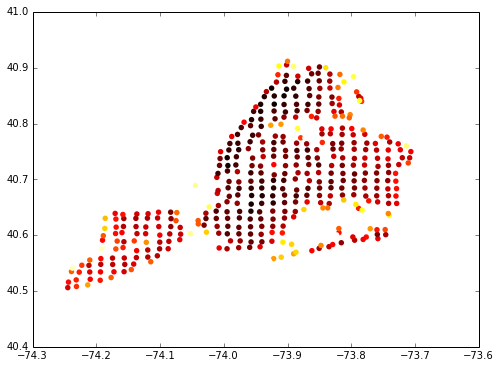

In [14]:
# visualize cells by complaining activity
c = log(C)
c = 1-c/max(c)
x=[cx[z] for z in range(0,cellnum)]
y=[cy[z] for z in range(0,cellnum)]
max(c)
plt.figure(figsize=(8,6))
plt.scatter (x,y,s=30,c=c,cmap='hot',lw=0)

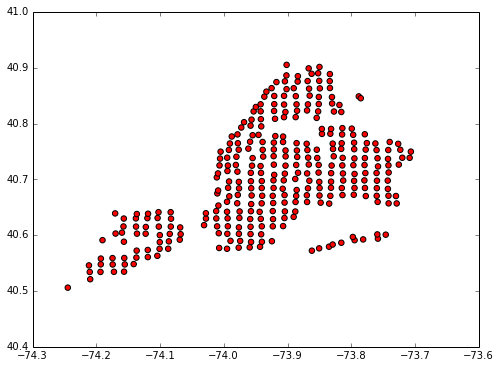

In [15]:
#filter only cells with over 500 complains in total
x500=[cx[z] for z in find(C>500)]
y500=[cy[z] for z in find(C>500)]
plt.figure(figsize=(8,6))
plt.scatter (x500,y500,s=30,c='red')

In [16]:
#normalize the matrix to deal with the relative complain type frequencies
X=matrix(X)
for z in range(0,cellnum):
    X[z,:]=X[z,:]/sum(X[z,:])
m=mean(X,0)    
for i in range(0,compnum):
    X[:,i]=(X[:,i]-m[0,i])
X500=X[C>500,:]

In [17]:
U, s, Vt = np.linalg.svd(X500)
V = Vt.T
ind = np.argsort(s)[::-1]
U = U[:, ind]
s = s[ind]
V = V[:, ind]
P=X500*np.matrix(V)

0.95008407225


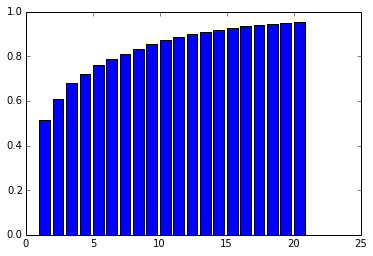

In [18]:
#visualize amount of information covered by PCAs and take 19 leading ones covering 95% of the entire infomation
sc=cumsum(np.array(s)**2/sum(np.array(s)**2))
plt.bar(range(1,21),sc[0:20])
Pl=P[:,0:19]
print(sc[18])

2 clusters: 0.340326640023
3 clusters: 0.263232978731
4 clusters: 0.274661252204
5 clusters: 0.204159456781
6 clusters: 0.208591585946
7 clusters: 0.188428681034
8 clusters: 0.187790019399
9 clusters: 0.179099858105
10 clusters: 0.182318253432
11 clusters: 0.184688925673
12 clusters: 0.187964938682
13 clusters: 0.185130123289
14 clusters: 0.176538913357
15 clusters: 0.173851057343
16 clusters: 0.188484825092
17 clusters: 0.188903945095
18 clusters: 0.178526620688
19 clusters: 0.181034086633
20 clusters: 0.176429011588
21 clusters: 0.180610278467
2 clusters: 0.340326640023


/Library/Frameworks/Python.framework/Versions/2.7/lib/python2.7/site-packages/numpy/core/_methods.py:59: RuntimeWarning: Mean of empty slice.
  warnings.warn("Mean of empty slice.", RuntimeWarning)


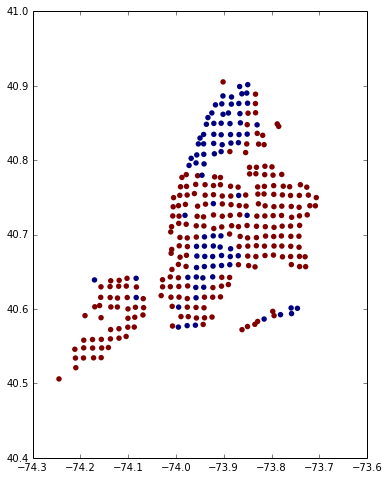

In [19]:
s=[0]*20
for k in range(0,20):
    est=KMeans(n_clusters=k+2,n_init=100)
    est.fit(Pl)
    s[k]=silhouette_score(Pl, est.labels_)
    print('{0} clusters: {1}'.format(k+2,s[k]))
k=np.argmax(s)    
est=KMeans(n_clusters=k+2,n_init=100)
est.fit(Pl)
labels=est.labels_
plt.figure(figsize=(6,8))
plt.scatter (x500,y500,s=30,c=labels.astype(np.float),lw=0)
print('{0} clusters: {1}'.format(k+2,silhouette_score(Pl, labels)))

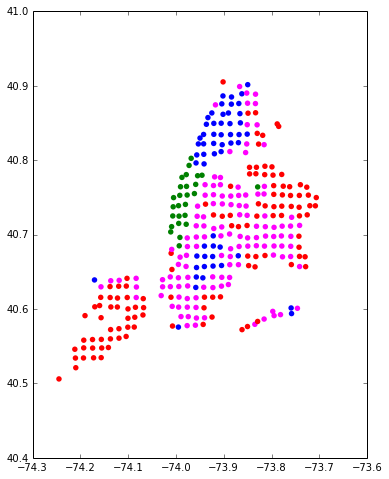

In [60]:
est=KMeans(n_clusters=4,n_init=100)
est.fit(Pl)
labels=est.labels_
plt.figure(figsize=(6,8))
colors=['blue','green','magenta','red']
plt.scatter (x500,y500,s=30,color=[colors[l] for l in labels],lw=0)

In [61]:
mC1=mean(X500[labels==0,:],0)
mC2=mean(X500[labels==1,:],0)
mC3=mean(X500[labels==2,:],0)
mC4=mean(X500[labels==3,:],0)
mind=find(m>0.02)
#print('Compain: average, red, green, blue, magenta')
clusters=pd.DataFrame({' ComplainType':['All'],'Avg':[1.0],'blue':[1.0],'green':[1.0],'magenta':[1.0],'red':[1.0]})
for c in mind:
    #print('{0}: {1}'.format(compinv[c],m[0,c]))
    clusters.loc[clusters.index.max()+1]=[compinv[c],m[0,c],m[0,c]+mC1[0,c],m[0,c]+mC2[0,c],m[0,c]+mC3[0,c],m[0,c]+mC4[0,c]]
    #print('{0}: {1:.3g},{2:.3g},{3:.3g},{4:.3g},{5:.3g}'.format(compinv[c],m[0,c],m[0,c]+mC1[0,c],m[0,c]+mC2[0,c],m[0,c]+mC3[0,c],m[0,c]+mC4[0,c]))
clusters

Compain: average, red, green, blue, magenta


,ComplainType,Avg,blue,green,magenta,red
0,All,1.000000,1.000000,1.000000,1.000000,1.000000
1,Blocked Driveway,0.040334,0.023519,0.012301,0.066612,0.038026
2,Damaged Tree,0.022073,0.004143,0.005472,0.015883,0.040403
3,Dirty Conditions,0.024018,0.015284,0.016775,0.029788,0.030101
4,GENERAL CONSTRUCTION,0.044642,0.128182,0.030247,0.057639,0.017086
5,HEATING,0.075057,0.219562,0.075530,0.094301,0.022359
6,Illegal Parking,0.042012,0.014558,0.042008,0.038181,0.056092
7,Missed Collection (All Materials),0.021114,0.004599,0.006314,0.014017,0.037450
8,Noise,0.021570,0.014154,0.084315,0.020683,0.019229
9,NONCONST,0.021218,0.057092,0.019419,0.030327,0.007170


### Delineating Manhattan using logit
Use the spatial coordinates of the cells to train the model over 311 data and see if it can reproduce the shape of Manhattan (without Harlem and other northern parts of it)

In [50]:
#train logistic regression over the leading PC's 
#logit=sklearn.linear_model.LogisticRegression(C=1, tol=0.001, fit_intercept=True, max_iter=100,penalty='l1')
#logit.fit(Pl,np.array(m500))
#me=logit.predict(Pl)
m500=[mh[z] for z in find(C>500)]
mdata=pd.DataFrame(Pl)
mdata.columns=['P1','P2','P3','P4','P5','P6','P7','P8','P9','P10','P11','P12','P13','P14','P15','P16','P17','P18','P19']
mdata['m']=m500

#m ~ P1+P2+P3+P4+P5+P6+P7+P8+P9+P10+P11+P12+P13+P14+P15+P16+P17+P18+P19
logit = smf.logit('m ~ P2+P3', data = mdata).fit()
me=logit.predict(mdata)
me1=me>0.5
print(logit.summary())
print('Errors={0}'.format(sum(me1!=m500)))

Optimization terminated successfully.
         Current function value: 0.013656
         Iterations 14
                           Logit Regression Results                           
Dep. Variable:                      m   No. Observations:                  321
Model:                          Logit   Df Residuals:                      318
Method:                           MLE   Df Model:                            2
Date:                Tue, 13 Oct 2015   Pseudo R-squ.:                  0.9486
Time:                        08:40:02   Log-Likelihood:                -4.3836
converged:                       True   LL-Null:                       -85.321
                                        LLR p-value:                 7.070e-36
                 coef    std err          z      P>|z|      [95.0% Conf. Int.]
------------------------------------------------------------------------------
Intercept    -13.2328      5.723     -2.312      0.021       -24.449    -2.017
P2           161.9735     70

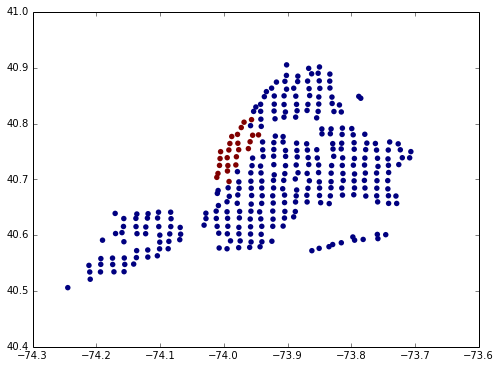

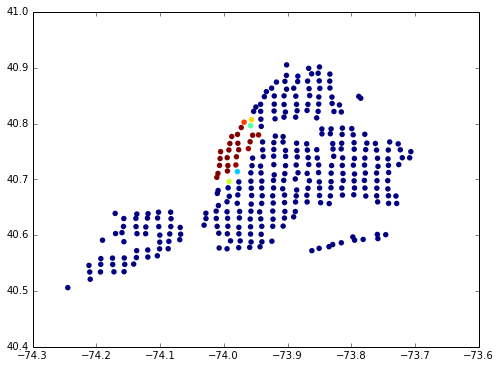

In [42]:
# visualize model "prediction" of where Manhattan is
plt.figure(figsize=(8,6))
plt.scatter (x500,y500,s=30,c=me1,lw=0)
plt.figure(figsize=(8,6))
plt.scatter (x500,y500,s=30,c=me,lw=0)